In [1]:
import harp
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from functools import reduce
import cv2
import numpy as np
import utils
import aeon.io.video as video
import aeon.analysis.movies as frame_helpers

harp_reader = harp.create_reader('device.yml', epoch=harp.REFERENCE_EPOCH)
session_data_reader = utils.SessionData()
rules_reader = utils.SessionData()
video_reader = utils.Video()

harp_datafolder = r'../temp_data/2024-03-04T20-16-10/Expander/'
settings_datafolder = r'../temp_data/2024-03-04T20-16-10/SessionSettings/'
rules_datafolder = r'../temp_data/2024-03-04T20-16-10/RuleSettings/'
video_datafolder = r'../temp_data/2024-03-04T20-16-10/VideoData/'

In [2]:
# read experiment metadata
session_settings = utils.load_json(session_data_reader, settings_datafolder)

rule_settings = utils.load_json(rules_reader, rules_datafolder)

print(session_settings)
print(rule_settings)

                                                                     metadata
2024-03-04 20:16:11.266496  {'lineMappings': {'odorMap': [DotMap(name='Odo...
                                                                     metadata
2024-03-04 20:16:11.266496  {'ruleAlias': 'Rule1', 'stateDefinitions': [{'...


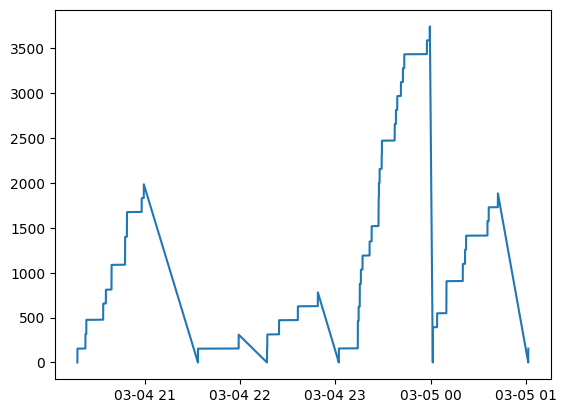

In [3]:
# read experiment video
video_data = utils.load_video(video_reader, video_datafolder)

plt.plot(video_data.index, video_data["_frame"])

In [5]:
# Read HARP device streams, conditioned on mappings found in the session metadata
metadata = session_settings.iloc[0]['metadata']
print(metadata)

# Extract line mappings from metadata
aux_line = f'Aux{metadata.lineMappings.auxLine}'
port_line = f'Out{metadata.lineMappings.portLine}'
vacuum_line = f'Out{metadata.lineMappings.vacuumLine}'
odorA = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorA'), None)}"
odorB = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorB'), None)}"
odorC = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorC'), None)}"
odorD = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorD'), None)}"

# Aux line containing poke events
poke_events = utils.load(harp_reader.AuxInState, harp_datafolder)[aux_line]

# times when outputs were set to HIGH (e.g. port valve opening, manifold valve opening)
outputs_HIGH = utils.load(harp_reader.OutputSet, harp_datafolder)
# times when outputs were set to LOW (e.g. port valve closing, manifold closing)
outputs_LOW = utils.load(harp_reader.OutputClear, harp_datafolder)

# convert LOW and HIGH events to port state dataframes
line_states = {
    "poke_events": poke_events,
    "port_line_state": utils.concat_digi_events(outputs_LOW[port_line], outputs_HIGH[port_line]),
    "vacuum_line_state": utils.concat_digi_events(outputs_LOW[vacuum_line], outputs_HIGH[vacuum_line]),
    "odorA_state": utils.concat_digi_events(outputs_LOW[odorA], outputs_HIGH[odorA]),
    "odorB_state": utils.concat_digi_events(outputs_LOW[odorB], outputs_HIGH[odorB]),
    "odorC_state": utils.concat_digi_events(outputs_LOW[odorC], outputs_HIGH[odorC]),
    "odorD_state": utils.concat_digi_events(outputs_LOW[odorD], outputs_HIGH[odorD])
}

# consolidate digital lines into as single DataFrame
merged = pd.merge(line_states["poke_events"], line_states["port_line_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["vacuum_line_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorA_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorB_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorC_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorD_state"], left_on="Time", right_on="Time", how="outer")

# rename columns according to metadata line mapping
merged.columns = line_states.keys()

# add additional meta information
merged['poke_count'] = (merged['poke_events'] * 1).cumsum(skipna=True).ffill()
merged['odor_count'] = (merged['odorA_state'] * 1).cumsum(skipna=True).ffill() + (merged['odorB_state'] * 1).cumsum(skipna=True).ffill() + \
                       (merged['odorC_state'] * 1).cumsum(skipna=True).ffill() + (merged['odorD_state'] * 1).cumsum(skipna=True).ffill()

print(merged)


DotMap(lineMappings=DotMap(odorMap=[DotMap(name='OdorA', line=6), DotMap(name='OdorB', line=7), DotMap(name='OdorC', line=8), DotMap(name='OdorD', line=9)], auxLine=0, portLine=0, vacuumLine=2), metadata=DotMap(switchTime1=0.01, switchTime2=0.02, useVacuum=False, vacuumDelay=0.005, vacuumDuration=0.05, chargeTime=0.2, minimumPokeTime=0.01, minOdorDelivery=0.1, maxOdorDelivery=8.0, loggingRootPath='C:\\Users\\court\\temp_data', animalId='CK002', remoteTransferRootPath='', maximumPokeTime=10.0, robocopyTimeInterval=3600.0, showHarpLeds=True, maxVideoLength=20.0), cameraProperties=DotMap(imagingRate=60.0, exposureTime=10000, postEventTime=2.5, preEventTime=2.5))
                              poke_events port_line_state vacuum_line_state  \
Time                                                                          
2024-03-04 20:16:15.527488231         NaN           False               NaN   
2024-03-04 20:16:15.581503868         NaN             NaN               NaN   
2024-03-04 20:16

C:\Users\erski\AppData\Local\Temp\ipykernel_9292\1209327517.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged['poke_count'] = (merged['poke_events'] * 1).cumsum(skipna=True).ffill()
C:\Users\erski\AppData\Local\Temp\ipykernel_9292\1209327517.py:46: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged['odor_count'] = (merged['odorA_state'] * 1).cumsum(skipna=True).ffill() + (merged['odorB_state'] * 1).cumsum(skipna=True).ffill() + \
C:\Users\erski\AppData\Local\Temp\ipykernel_9292\1209327517.py:47: FutureWarning: Downcasting object dtype arrays 

Current state
poke_events           True
port_line_state      False
vacuum_line_state      NaN
odorA_state           True
odorB_state          False
odorC_state          False
odorD_state          False
poke_count             1.0
odor_count             1.0
Name: 2024-03-04 20:19:00.503903866, dtype: object
Beam break on: 2024-03-04 20:19:00.503903866, off: 2024-03-04 20:19:00.932223797
Time port open: 2024-03-04 20:19:00.531487942, close: 2024-03-04 20:19:00.964479923
Time odor open: 2024-03-04 20:16:15.614496231, close: 2024-03-04 20:19:00.982495785
Next odor open: 2024-03-04 20:19:01.012479782


C:\Users\erski\AppData\Local\Temp\ipykernel_9292\1412668696.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cur_state = merged.ffill().loc[merged.index <= poke_event_time].iloc[-1]
C:\Users\erski\AppData\Local\Temp\ipykernel_9292\1412668696.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.plot(event_data["poke_events"].ffill(), drawstyle = 'steps-post')


[Text(0, -0.25, 'event'),
 Text(0, 0.55, 'poke'),
 Text(0, 1.65, 'port_line'),
 Text(0, 2.75, 'odorA'),
 Text(0, 3.85, 'odorB'),
 Text(0, 4.95, 'odorC'),
 Text(0, 6.05, 'video_frames')]

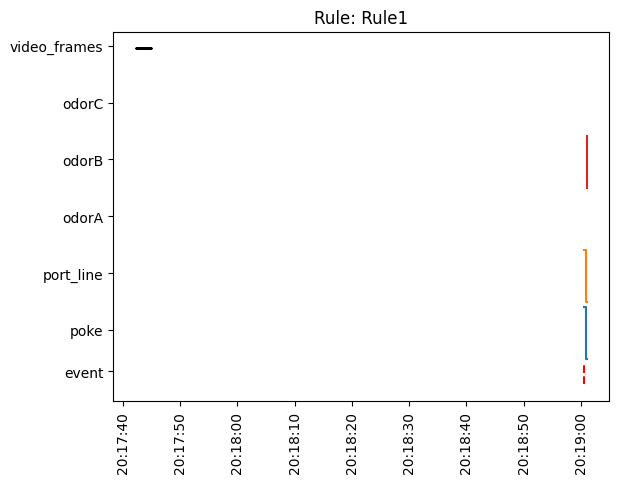

In [19]:
# Using the consolidated data sets, do an example plot centered around a poke event

# Get all the poke onset events, then index to pick a single event. Ultimately we just need to choose a timestamp value to center our plot around.
poke_event = merged["poke_events"][merged["poke_events"]==True].iloc[[0]] # as an example we here pick the time 3rd poke event time
poke_event_time = poke_event.index[0]

# Create a time window around the time of this event
time_offset = 100 # 10 second time offset around the event
start_time = poke_event_time - pd.Timedelta(seconds=time_offset)
end_time = poke_event_time + pd.Timedelta(seconds=time_offset)

# Slice the data in this time window
event_data = merged[start_time : end_time]
event_vid = video_data[start_time : end_time]

# additional meta information
cur_state = merged.ffill().loc[merged.index <= poke_event_time].iloc[-1]
cur_odor = [state for state in ['odorA_state', 'odorB_state', 'odorC_state', 'odorD_state'] if cur_state[state]][0]
current_rule = rule_settings[rule_settings.index <= poke_event_time]["metadata"].iloc[-1]

time_beam_break_on = poke_event_time
time_beam_break_off = merged.loc[(merged['poke_events'] == False) & (merged.index > poke_event_time)].index[0]

time_port_open = merged.loc[(merged['port_line_state'] == True) & (merged.index > poke_event_time)].index[0]
time_port_close = merged.loc[(merged['port_line_state'] == False) & (merged.index > poke_event_time)].index[0]

time_odor_open = merged.loc[(merged[cur_odor] == True) & (merged.index <= poke_event_time)].index[0]
time_odor_close = merged.loc[(merged[cur_odor] == False) & (merged.index > poke_event_time)].index[0]

next_poke_valves = (merged[merged.index > time_odor_close])[['odorA_state', 'odorB_state', 'odorC_state', 'odorD_state']].sum(axis=1)
next_odor_time = next_poke_valves[next_poke_valves == 1].index[0]

print('Current state')
print(cur_state)
print(f'Beam break on: {time_beam_break_on}, off: {time_beam_break_off}')
print(f'Time port open: {time_port_open}, close: {time_port_close}')
print(f'Time odor open: {time_odor_open}, close: {time_odor_close}')
print(f'Next odor open: {next_odor_time}')

# Construct a plot of this time window
fig = plt.figure()

plt.plot([poke_event_time, poke_event_time], [-0.5, -0.1], c='r', linestyle='dashed')
plt.plot(event_data["poke_events"].ffill(), drawstyle = 'steps-post')
plt.plot(event_data["port_line_state"].ffill() + 1.1, drawstyle = 'steps-post')
plt.plot(event_data["odorA_state"].ffill() + 2.2, drawstyle = 'steps-post')
plt.plot(event_data["odorB_state"].ffill() + 3.3, drawstyle = 'steps-post')
plt.plot(event_data["odorC_state"].ffill() + 4.4, drawstyle = 'steps-post')
plt.scatter(event_vid.index, np.ones((1, len(event_vid.index))) * 6, c='k', s=0.1)
plt.xticks(rotation=90)
plt.title(f'Rule: {current_rule.ruleAlias}')

ax = fig.axes[0]
ax.set_yticks([-0.25, 0.55, 1.65, 2.75, 3.85, 4.95, 6.05])
ax.set_yticklabels(['event', 'poke', 'port_line', 'odorA', 'odorB', 'odorC', 'video_frames'])

In [17]:
# Get all frames
frames = [f for f in video.frames(event_vid)]

# create annotated video around this event
annotated_frames = []
for i, f in enumerate(frames):
    cur_t = event_vid.index[i]
    relative_t = (cur_t - poke_event_time).total_seconds()
    cur_state = merged.ffill().loc[merged.index <= cur_t].iloc[-1]
    current_rule = rule_settings[rule_settings.index <= cur_t]["metadata"].iloc[-1]
    cv2.putText(f, f'Rule : {current_rule.ruleAlias}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)
    cv2.putText(f, f'HARP Time : {cur_t}', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)
    cv2.putText(f, f'Time to event (s) : {relative_t}', (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)

    cv2.putText(f, f"Aux state : {cur_state['poke_events']}", (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if cur_state['poke_events'] else (0, 0, 255), 2, 1)
    cv2.putText(f, f"Port state : {cur_state['port_line_state']}", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if cur_state['port_line_state'] else (0, 0, 255), 2, 1)
    cv2.putText(f, f"OdorA state : {cur_state['odorA_state']}", (10, 180), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if cur_state['odorA_state'] else (0, 0, 255), 2, 1)
    cv2.putText(f, f"OdorB state : {cur_state['odorB_state']}", (10, 210), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if cur_state['odorB_state'] else (0, 0, 255), 2, 1)
    cv2.putText(f, f"OdorC state : {cur_state['odorC_state']}", (10, 240), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if cur_state['odorC_state'] else (0, 0, 255), 2, 1)

    cv2.putText(f, f"Poke count : {cur_state['poke_count']}", (10, 270), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)
    annotated_frames.append(f)

print(annotated_frames)
video.export(annotated_frames, f'{video_datafolder}Event-{str(poke_event_time).replace(" ", "").replace(":", "T")}.mp4', 50)

[]
